In [1]:
import sys
sys.path.append(r'/home1/roeyshafran/BrainCap/Mind-Cap/code/Mind_Vis_utils/')

from fmri_caption import GPTCaptionModel, create_fmri_encoder_from_pretrained,top_k_top_p_filtering, set_parameter_requires_grad
from dataset import create_BOLD5000_dataset
from torch.utils.data import DataLoader, Subset
import torch
import torch.optim as optim
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer, util
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
#import optuna
%matplotlib inline

#### Setup

In [2]:
# Parameters
BATCH_SIZE = 8
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
LEARNING_RATE = 1e-4
NUM_EPOCHS = 5
TRIAL_NUM_TRAIN_EXAMPLES = BATCH_SIZE*30
TRIAL_NUM_VAL_EXAMPLES = BATCH_SIZE*10
WARMUP_STEPS = 500

cuda:0


In [4]:
# Pretrained files
path_fmri_encoder = r"/databases/roeyshafran/BrainCap/pretrains/pretrain_metafile.pth"
path_BOLD_dataset = r"/databases/roeyshafran/BrainCap/data/BOLD5000/CSI1_dataset.pth"

# create BOLD5000 dataset
BOLD_dataset = torch.load(path_BOLD_dataset)
bold_train, bold_test = BOLD_dataset['train'], BOLD_dataset['test']


In [5]:
test_idx, val_idx = train_test_split(list(range(len(bold_test))),test_size=0.5)
bold_val = Subset(bold_test, val_idx)
bold_test = Subset(bold_test, test_idx)

train_dl = DataLoader(bold_train, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(bold_val, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(bold_test, batch_size=BATCH_SIZE, shuffle=True)


#### Function Delerations

In [6]:
@torch.no_grad()
def calculate_semantic_similarity(generated_caption, real_caption, device):
    sentence_model = SentenceTransformer('all-mpnet-base-v2').to(device)
    embed_generated = sentence_model.encode(generated_caption, convert_to_tensor=True)
    embed_real_caption = sentence_model.encode(real_caption, convert_to_tensor=True)
      
    return util.pytorch_cos_sim(embed_generated, embed_real_caption)

def define_GPTCaption_model(encoder, trial=None, projection_sizes=None):
    if trial:
        # TODO: Add Optuna support. If trial is used, override projection_sizes with Optuna suggestion
        num_layers = trial.suggest_int("num_projection_layers", 1, 5)
        projection_sizes = [encoder.embed_dim]*num_layers
    gpt_decoder = GPTCaptionModel(encoder.num_patches, encoder.embed_dim, projection_sizes)
    set_parameter_requires_grad(gpt_decoder.embedding_space_projection, feature_extraction=False)
    set_parameter_requires_grad(gpt_decoder.gpt, feature_extraction=True)
    #set_parameter_requires_grad(gpt_decoder.tokenizer, feature_extraction=True)
    #for param in gpt_decoder.tokenizer.parameters():
    #  param.requires_grad = False

    return gpt_decoder

def print_batch(batch, fontsize=5, caption_as_title=False):
    N = int(np.ceil(np.sqrt(len(batch))))
    fig, axs = plt.subplots(N,N)
    for idx, ax in enumerate(axs.flatten()):
        try:
            ax.imshow(batch[idx][2])
            if caption_as_title:
                ax.set_title(f"({idx}) Generated: {batch[idx][0]}\n   Real: {batch[idx][1]}", fontsize=fontsize)
            else:
                print(f"({idx}) Generated: {batch[idx][0]}\n   Real: {batch[idx][1]}")
        except IndexError:
            pass
        ax.set_xticks([],[])
        ax.set_yticks([],[])
      
    fig.tight_layout()




def calculate_accuracy_on_test(encoder, decoder, dataloader, device, return_best_batch=False):
    running_accuracy = 0
    best_accuracy = 0
    for batch in dataloader:
        fmri_prefix = encoder.forward(batch['fmri'].to(device))
        generated_caption = decoder.generate_caption(fmri_prefix, device)
        accuracy = torch.mean(calculate_semantic_similarity(generated_caption, batch['caption'], device)).item()
        running_accuracy += accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_batch = list(zip(generated_caption, batch['caption'], batch['image']))
    
    if return_best_batch:
        return running_accuracy / len(dataloader), best_batch
    else:
        return running_accuracy / len(dataloader)
        

def objective(encoder, decoder, train_dl, val_dl, device, trial=None):

    # Generate the optimizers
    if trial:
        lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
        optimizer_name = trial.suggest_categorial("optimizer", ['Adam', 'AdamW', "SGD"])
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr)
        batch_size = trial.suggest_int("batch_size", 1, 10)
    else:
        lr = LEARNING_RATE
        optimizer = optim.AdamW(encoder.parameters(), lr)
        batch_size = BATCH_SIZE
        #scheduler = get_linear_schedule_with_warmup(
    #optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=NUM_EPOCHS*len(train_dl)
    #)

    decoder.train()
    encoder.eval()
    print("\n\n")
    running_loss = []
    running_semantic_accuracy = []
    val_accuracy = []
    for epoch in range(NUM_EPOCHS):
        print(f"** Starting epoch {epoch} **")
        with tqdm(train_dl, unit='batch') as tepoch:
            semantic_accuracy = 0
            for batch_idx, batch in enumerate(tepoch):
                if batch_idx * batch_size >= TRIAL_NUM_TRAIN_EXAMPLES:
                    break
                
                tepoch.set_description(f"Epoch: {epoch}")

                #batch_fmri = batch['fmri'].to(device)
                batch_fmri = batch['fmri']
                batch_fmri = batch_fmri.to(device)
                batch_caption = batch['caption']

                #print(f">>>> encoding fmri scans ", end="")
                fmri_prefix = encoder.forward(batch_fmri)
                #print(f"-> tokenizing captions ", end="")
                tokens, attention_mask = decoder.tokenizer(batch_caption, return_tensors="pt", padding=True).values()
                tokens, attention_mask, fmri_prefix = tokens.to(device), attention_mask.to(device), fmri_prefix.to(device)
                #print(f"-> decoding ")
                outputs = decoder.forward(tokens, fmri_prefix, attention_mask)
                logits = outputs.logits[:, decoder.prefix_length-1:-1]

                loss = F.cross_entropy(
                    logits.reshape(-1, logits.shape[-1]),
                    tokens.flatten(),
                    ignore_index=decoder.tokenizer.pad_token_id
                      )
                decoder.zero_grad(set_to_none=True)
                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()
                #scheduler.step()
                #print(f">>>> batch {batch_idx} finished", end="\r")

                # Eval semantic accuracy
                if batch_idx % 10 == 0:
                    with torch.no_grad():
                        generated_caption = decoder.generate_caption(fmri_prefix, device)
                        semantic_accuracy = torch.mean(calculate_semantic_similarity(generated_caption, batch_caption, device)).item()
                        running_semantic_accuracy.append(semantic_accuracy)
                        running_loss.append(loss.item())
                
                tepoch.set_postfix(loss=loss.item(), train_accuracy=semantic_accuracy)

                # Free GPU memory
                del batch_fmri, batch_caption, tokens, attention_mask, logits, outputs, loss
                torch.cuda.empty_cache()
        val_accuracy.append(calculate_accuracy_on_test(encoder, decoder, val_dl, device, return_best_batch=False))
        print(f"---- epoch loss: {np.mean(running_loss[int(np.floor((epoch*len(train_dl))/10 + 1)):-1]):.4}, test accuracy: {np.mean(running_semantic_accuracy[int(np.floor((epoch*len(train_dl))/10 + 1)):-1]):.4}, validation accuracy: {val_accuracy[epoch]:.4} ---- ")

        trial.report(val_accuracy, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_accuracy



#### Optuna Tuning

In [ ]:
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(study_name="BOLD5000-caption", direction="maximize", sampler=sampler)
study.optimie(objective, n_trials=100, timeout=1000)

pruned_trails = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print(" Number of finished trials: ", len(study.trials))
print(" Number of pruned trials: ", len(pruned_trials))
print(" Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print(" Value: ", trial.value)

print(" Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key, value))

In [ ]:
optuna.visualization.plot_param_importance(study)

In [ ]:
optuna.visualization.plot_contour(study, params=['lr', 'batch_size'])

#### Training Loop

In [7]:
# Get encoder-decoder
encoder = create_fmri_encoder_from_pretrained(path_fmri_encoder, bold_train.num_voxels, feature_extraction=True)
encoder = encoder.to(device)
decoder = define_GPTCaption_model(encoder, projection_sizes=[encoder.embed_dim])
decoder = decoder.to(device)
optimizer = optim.AdamW(decoder.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=NUM_EPOCHS*len(train_dl)
    )
use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
    


Position interpolate from 262 to 106
missing keys: ['mask_token']
unexpected keys: ['decoder_pos_embed', 'decoder_embed.weight', 'decoder_embed.bias', 'decoder_blocks.0.norm1.weight', 'decoder_blocks.0.norm1.bias', 'decoder_blocks.0.attn.qkv.weight', 'decoder_blocks.0.attn.qkv.bias', 'decoder_blocks.0.attn.proj.weight', 'decoder_blocks.0.attn.proj.bias', 'decoder_blocks.0.norm2.weight', 'decoder_blocks.0.norm2.bias', 'decoder_blocks.0.mlp.fc1.weight', 'decoder_blocks.0.mlp.fc1.bias', 'decoder_blocks.0.mlp.fc2.weight', 'decoder_blocks.0.mlp.fc2.bias', 'decoder_blocks.1.norm1.weight', 'decoder_blocks.1.norm1.bias', 'decoder_blocks.1.attn.qkv.weight', 'decoder_blocks.1.attn.qkv.bias', 'decoder_blocks.1.attn.proj.weight', 'decoder_blocks.1.attn.proj.bias', 'decoder_blocks.1.norm2.weight', 'decoder_blocks.1.norm2.bias', 'decoder_blocks.1.mlp.fc1.weight', 'decoder_blocks.1.mlp.fc1.bias', 'decoder_blocks.1.mlp.fc2.weight', 'decoder_blocks.1.mlp.fc2.bias', 'decoder_blocks.2.norm1.weight', 'dec

In [8]:
# Train
decoder.train()
encoder.eval()
print("\n\n")
running_loss = []
running_semantic_accuracy = []
val_accuracy = []
for epoch in range(NUM_EPOCHS):
    print(f"** Starting epoch {epoch} **")
    with tqdm(train_dl, unit='batch') as tepoch:
      semantic_accuracy = 0
      for batch_idx, batch in enumerate(tepoch):
          tepoch.set_description(f"Epoch: {epoch}")

          #batch_fmri = batch['fmri'].to(device)
          batch_fmri = batch['fmri']
          batch_fmri = batch_fmri.to(device)
          batch_caption = batch['caption']

          with torch.cuda.amp.autocast(enabled=use_amp):
            #print(f">>>> encoding fmri scans ", end="")
            fmri_prefix = encoder.forward(batch_fmri)
            #print(f"-> tokenizing captions ", end="")
            tokens, attention_mask = decoder.tokenizer(batch_caption, return_tensors="pt", padding=True).values()
            tokens, attention_mask, fmri_prefix = tokens.to(device), attention_mask.to(device), fmri_prefix.to(device)
            #print(f"-> decoding ")
            outputs = decoder.forward(tokens, fmri_prefix, attention_mask)
            logits = outputs.logits[:, decoder.prefix_length-1:-1]
            loss = F.cross_entropy(logits.reshape(-1, logits.shape[-1]), tokens.flatten(), ignore_index=decoder.tokenizer.pad_token_id)

          decoder.zero_grad(set_to_none=True)
          optimizer.zero_grad(set_to_none=True)
          scaler.scale(loss).backward()
          scaler.step(optimizer)
          scaler.update()
          scheduler.step()
          #print(f">>>> batch {batch_idx} finished", end="\r")

          # Eval semantic accuracy
          if batch_idx % 10 == 0:
            with torch.no_grad():
              generated_caption = decoder.generate_caption(fmri_prefix, device)
              semantic_accuracy = torch.mean(calculate_semantic_similarity(generated_caption, batch_caption, device)).item()
              running_semantic_accuracy.append(semantic_accuracy)
              running_loss.append(loss.item())
          
          tepoch.set_postfix(loss=loss.item(), train_accuracy=semantic_accuracy)

          # Free GPU memory
          del batch_fmri, batch_caption, tokens, attention_mask, logits, outputs, loss
          torch.cuda.empty_cache()
    val_accuracy.append(calculate_accuracy_on_test(encoder, decoder, val_dl, device, return_best_batch=False))
    print(f"---- epoch loss: {np.mean(running_loss[int(np.floor((epoch*len(train_dl))/10 + 1)):-1]):.4}, test accuracy: {np.mean(running_semantic_accuracy[int(np.floor((epoch*len(train_dl))/10 + 1)):-1]):.4}, validation accuracy: {val_accuracy[epoch]:.4} ---- ")





** Starting epoch 0 **


Epoch: 0:   0%|          | 0/1258 [00:00<?, ?batch/s]/opt/conda/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Epoch: 0: 100%|██████████| 1258/1258 [05:26<00:00,  3.86batch/s, loss=3.2, train_accuracy=0.0774] 


---- epoch loss: 4.017, test accuracy: 0.08472, validation accuracy: 0.1137 ---- 
** Starting epoch 1 **


Epoch: 1: 100%|██████████| 1258/1258 [05:27<00:00,  3.84batch/s, loss=2.79, train_accuracy=0.0771]


---- epoch loss: 3.417, test accuracy: 0.1003, validation accuracy: 0.1143 ---- 
** Starting epoch 2 **


Epoch: 2: 100%|██████████| 1258/1258 [05:23<00:00,  3.89batch/s, loss=3.02, train_accuracy=0.0777]


---- epoch loss: 3.323, test accuracy: 0.105, validation accuracy: 0.09927 ---- 
** Starting epoch 3 **


Epoch: 3: 100%|██████████| 1258/1258 [05:19<00:00,  3.94batch/s, loss=2.35, train_accuracy=0.101] 


---- epoch loss: 3.298, test accuracy: 0.1087, validation accuracy: 0.1043 ---- 
** Starting epoch 4 **


Epoch: 4: 100%|██████████| 1258/1258 [05:23<00:00,  3.89batch/s, loss=2.78, train_accuracy=0.11]  


---- epoch loss: 3.157, test accuracy: 0.1063, validation accuracy: 0.1067 ---- 


#### Save Model

In [10]:
to_save = {
    'decoder': decoder.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict()
}

torch.save(to_save, r'/databases/roeyshafran/BrainCap/Checkpoints/encoder_14012023.pth')

#### Visualize Results

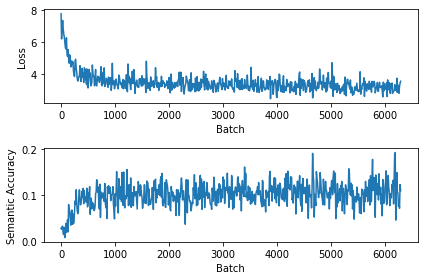

In [11]:
fig, axs = plt.subplots(2,1)
batch_iterations = np.arange(0, len(train_dl)*NUM_EPOCHS+1, 10)
axs[0].plot(batch_iterations, running_loss)
axs[0].set_xlabel('Batch')
axs[0].set_ylabel('Loss')
axs[1].plot(batch_iterations, running_semantic_accuracy)
axs[1].set_xlabel('Batch')
axs[1].set_ylabel('Semantic Accuracy')
fig.tight_layout()

In [ ]:
sent1 = "Python is a snake"
sent2 = "I like Python because I can build AI applications"

calculate_semantic_similarity(sent1,sent2, device)

tensor([[0.3671]], device='cuda:0')

In [12]:
acc, best_batch = calculate_accuracy_on_test(encoder, decoder, test_dl, device, return_best_batch=True)
#plt.figure()
#plt.imshow(batch['image'][0])

(0) Generated: <|endoftext|>The whole room is covered in water.
   Real: There is a mirror and trash can and a mirror with two cats nearby.
(1) Generated: <|endoftext|>Fancy blanket with pockets and snack containers upstairs with furniture scattered throughout.
   Real: Several park benches are painted all different colors.
(2) Generated: <|endoftext|>Some kitchen tools stand on the kitchen counter.
   Real: a white sink and a toilet in a bathroom
(3) Generated: <|endoftext|>A plate with lunch omelets and a scoop of spinach in it.
   Real: a number of sadnwiches and wine on a cloth near a body of water
0.11979344834884008


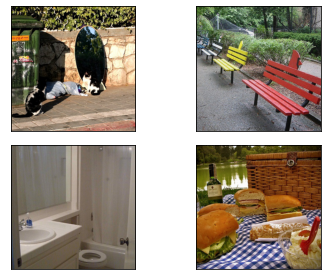

In [14]:
print_batch(best_batch, fontsize=10, caption_as_title=False)
print(acc)

TypeError: object of type 'bool' has no len()